## 1. 이미지 불러오기

In [1]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
print("🌫🛸")

🌫🛸


#### opencv는 bgr순

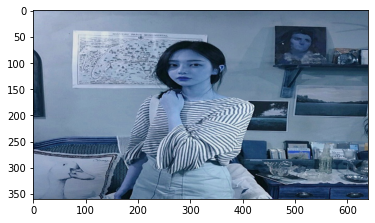

In [2]:
import os
my_image_path = os.getenv('HOME')+'/aiffel/camera_sticker/images/손화민.png'
img_bgr = cv2.imread(my_image_path)    #- OpenCV로 이미지를 읽어서
img_bgr = cv2.resize(img_bgr, (640, 360))    # 640x360의 크기로 Resize
img_show = img_bgr.copy()      #- 출력용 이미지 별도 보관
plt.imshow(img_bgr)
plt.show()

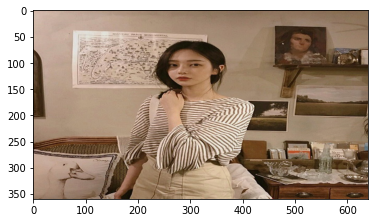

In [3]:
# plt.imshow 이전에 RGB 이미지로 바꾸는 것을 잊지마세요. 
img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
plt.imshow(img_rgb)
plt.show()

## 2 . dlib face detector 적용

In [4]:
import dlib
detector_hog = dlib.get_frontal_face_detector()   #- detector 선언
print("🌫🛸")

🌫🛸


In [5]:
img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB) #rgb 입력 필요
dlib_rects = detector_hog(img_rgb, 1)   #- (image, num of img pyramid)
print("🌫🛸")

🌫🛸


rectangles[[(256, 90) (308, 141)]]


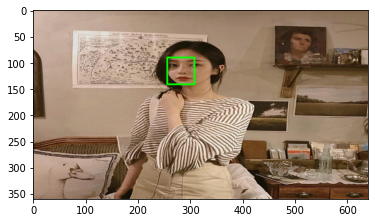

In [6]:
print(dlib_rects)   # 찾은 얼굴영역 좌표

for dlib_rect in dlib_rects:
    l = dlib_rect.left()
    t = dlib_rect.top()
    r = dlib_rect.right()
    b = dlib_rect.bottom()

    cv2.rectangle(img_show, (l,t), (r,b), (0,255,0), 2, lineType=cv2.LINE_AA)

img_show_rgb =  cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB)
plt.imshow(img_show_rgb)
plt.show()

In [7]:
import os
model_path = os.getenv('HOME')+'/aiffel/camera_sticker/models/shape_predictor_68_face_landmarks.dat'
landmark_predictor = dlib.shape_predictor(model_path) #landmark_predictor 선언
print("🌫🛸")

🌫🛸


In [8]:
#landmark 지정
list_landmarks = []
for dlib_rect in dlib_rects:
    points = landmark_predictor(img_rgb, dlib_rect) #img(rgb) , dlib_rect
    list_points = list(map(lambda p: (p.x, p.y), points.parts())) #(x,y) list
    list_landmarks.append(list_points)

print(len(list_landmarks[0])) #68 landmarks

68


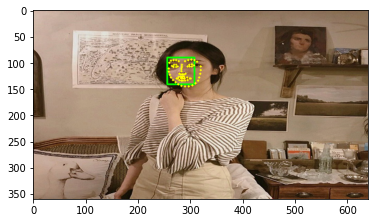

In [9]:
#landmark 표시
for landmark in list_landmarks:
    for idx, point in enumerate(list_points):
        cv2.circle(img_show, point, 2, (0, 255, 255), -1) # yellow

img_show_rgb = cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB)
plt.imshow(img_show_rgb)
plt.show()

## 3. 얼굴에 스티커 씌우기

$$X = X_{nose}$$
$$Y = Y_{nose}$$

#### 고양이 콧수염 스티커이므로 Nose 좌표를 그대로 사용했다.

In [10]:
#스티커 좌표 확인

print("Nose center : ",landmark[30]) # nose center index : 30 (미리 정해진 값)

for dlib_rect, landmark in zip(dlib_rects, list_landmarks):
    x = landmark[30][0]  # x축
    y = landmark[30][1]  #y축
    w = dlib_rect.width()
    h = dlib_rect.width()
    print ('(x,y) : (%d,%d)'%(x,y))
    print ('(w,h) : (%d,%d)'%(w,h))

Nose center :  (283, 116)
(x,y) : (283,116)
(w,h) : (53,53)


#### 스티커 이미지 확인

(53, 53, 3)


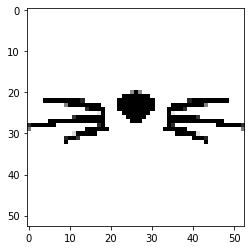

In [11]:
import os
sticker_path = os.getenv('HOME')+'/aiffel/camera_sticker/images/cat-whiskers.png'
img_sticker = cv2.imread(sticker_path)
img_sticker = cv2.resize(img_sticker, (w,h))
plt.imshow(cv2.cvtColor(img_sticker, cv2.COLOR_BGR2RGB))
print (img_sticker.shape)

#### 이미지 시작점이 좌측 상단이므로 x, y  변경

In [12]:
refined_x = x - w // 2  # left
refined_y = y - h // 2  # top
print ('(x,y) : (%d,%d)'%(refined_x, refined_y))

(x,y) : (257,90)


#### 음수 index ? ndarray에선 처리 불가하므로 예외 처리

In [13]:
if refined_x < 0 and refined_y < 0 :
    img_sticker = img_sticker[-refined_y:][-refined_x:] # image sticker crop
    refined_y , refined_x = 0 , 0 

elif refined_y < 0 :
    img_sticker = img_sticker[-refined_y:]
    refined_y = 0
    
elif refined_x < 0 :
    img_sticker = img_sticker[:][-refined_x:]
    refined_x = 0
    
else :
    pass

print (img_sticker.shape)
print ('(x,y) : (%d,%d)'%(refined_x, refined_y)) #스티커 좌표 재지정

(53, 53, 3)
(x,y) : (257,90)


#### 스티커 영역 표시

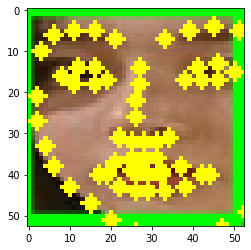

In [14]:
sticker_area = img_show[refined_y:refined_y+img_sticker.shape[0],refined_x:refined_x+img_sticker.shape[1]]
plt.imshow(cv2.cvtColor(sticker_area, cv2.COLOR_BGR2RGB))

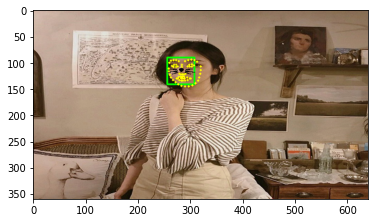

In [15]:
img_show[refined_y:refined_y+img_sticker.shape[0],refined_x:refined_x+img_sticker.shape[1]] = \
    np.where(img_sticker==255,sticker_area,img_sticker).astype(np.uint8) #스티커 적용

plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.show()

#### bounding box와 landmark 제거 , 스티커 투명도 조절

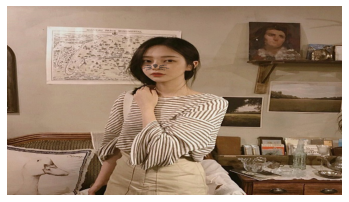

In [16]:
#img_show는 이미 bounding box와 landmark돼 있으므로 img_bgr에 새로 스티커를 붙인다.
img_bgr_copy = img_bgr.copy() #img_bgr 원본 유지하기 위해서 copy

sticker_area = img_bgr_copy[refined_y:refined_y+img_sticker.shape[0],refined_x:refined_x+img_sticker.shape[1]]
img_bgr_copy[refined_y:refined_y+img_sticker.shape[0],refined_x:refined_x+img_sticker.shape[1]] = \
    np.where(img_sticker==255,sticker_area,img_sticker).astype(np.uint8) #img_sticker==255이면 sticker_area
plt.axis('off')

# 결과 출력
img_blended = cv2.addWeighted(img_bgr,0.5,img_bgr_copy,0.5,0) #2,4번째 요소들의 합을 1로 유지하면 스티커의 투명도를 조절할 수 있다.
plt.imshow(cv2.cvtColor(img_blended, cv2.COLOR_BGR2RGB))
plt.show()

## 4. 다양한 이미지에 적용

#### 이미지 확인

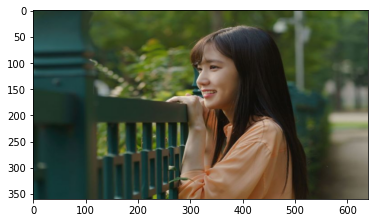

In [19]:
my_image_path = os.getenv('HOME')+'/aiffel/camera_sticker/images/사람_측면.png'
img_bgr = cv2.imread(my_image_path)    #- OpenCV로 이미지를 읽어서
img_bgr = cv2.resize(img_bgr, (640, 360))    # 640x360의 크기로 Resize
img_show = img_bgr.copy()      #- 출력용 이미지 별도 보관

img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
plt.imshow(img_rgb)
plt.show()

#### 얼굴 검출

rectangles[[(285, 86) (374, 176)]]


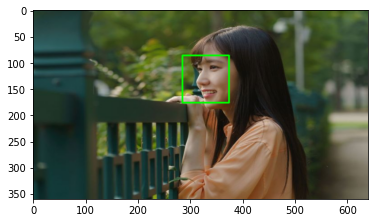

In [20]:
detector_hog = dlib.get_frontal_face_detector()   #- detector 선언
dlib_rects = detector_hog(img_rgb, 1)   #- (image, num of img pyramid)

print(dlib_rects)   # 찾은 얼굴영역 좌표

for dlib_rect in dlib_rects:
    l = dlib_rect.left()
    t = dlib_rect.top()
    r = dlib_rect.right()
    b = dlib_rect.bottom()

    cv2.rectangle(img_show, (l,t), (r,b), (0,255,0), 2, lineType=cv2.LINE_AA)

img_show_rgb =  cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB)
plt.imshow(img_show_rgb)
plt.show()

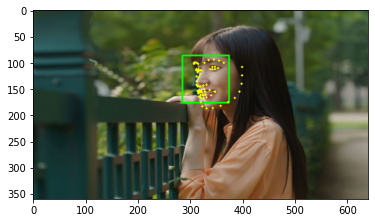

In [21]:
landmark_predictor = dlib.shape_predictor(model_path) #landmark_predictor 선언

list_landmarks = [] #landmarks

#landmark 지정
for dlib_rect in dlib_rects:
    points = landmark_predictor(img_rgb, dlib_rect) #img(rgb) , dlib_rect
    list_points = list(map(lambda p: (p.x, p.y), points.parts())) #(x,y) list
    list_landmarks.append(list_points)

#landmark 표시
for landmark in list_landmarks:
    for idx, point in enumerate(list_points):
        cv2.circle(img_show, point, 2, (0, 255, 255), -1) # yellow

img_show_rgb = cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB)
plt.imshow(img_show_rgb)
plt.show()

#### 스티커 확인

In [22]:
#스티커 좌표 확인

print("Nose center : ",landmark[30]) # nose center index : 30 (미리 정해진 값)

for dlib_rect, landmark in zip(dlib_rects, list_landmarks):
    x = landmark[30][0]  # x축
    y = landmark[30][1] #y축
    w = dlib_rect.width()
    h = dlib_rect.width()
    print ('(x,y) : (%d,%d)'%(x,y))
    print ('(w,h) : (%d,%d)'%(w,h))

Nose center :  (313, 136)
(x,y) : (313,136)
(w,h) : (90,90)


(90, 90, 3)
(x,y) : (268,91)


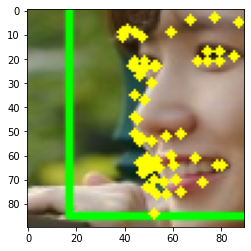

In [26]:
sticker_path = os.getenv('HOME')+'/aiffel/camera_sticker/images/cat-whiskers.png'
img_sticker = cv2.imread(sticker_path)
img_sticker = cv2.resize(img_sticker, (w,h)) #스티커 크기 조절

refined_x = x - w // 2  # left
refined_y = y - h // 2  # top

#x , y 음수 방지
if refined_x < 0 and refined_y < 0 :
    img_sticker = img_sticker[-refined_y:][-refined_x:] # image sticker crop
    refined_y , refined_x = 0 , 0 

elif refined_y < 0 :
    img_sticker = img_sticker[-refined_y:]
    refined_y = 0
    
elif refined_x < 0 :
    img_sticker = img_sticker[:][-refined_x:]
    refined_x = 0
    
else :
    pass

print (img_sticker.shape)
print ('(x,y) : (%d,%d)'%(refined_x, refined_y)) #스티커 좌표 재지정

sticker_area = img_show[refined_y:refined_y+img_sticker.shape[0],refined_x:refined_x+img_sticker.shape[1]]
plt.imshow(cv2.cvtColor(sticker_area, cv2.COLOR_BGR2RGB)) #스티커 영역 표시

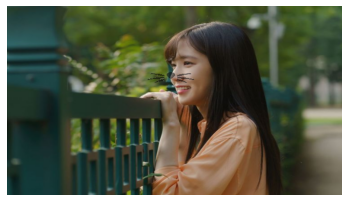

In [27]:
#img_show는 이미 bounding box와 landmark돼 있으므로 img_bgr에 새로 스티커를 붙인다.
img_bgr_copy = img_bgr.copy() #img_bgr 원본 유지하기 위해서 copy

sticker_area = img_bgr_copy[refined_y:refined_y+img_sticker.shape[0],refined_x:refined_x+img_sticker.shape[1]]
img_bgr_copy[refined_y:refined_y+img_sticker.shape[0],refined_x:refined_x+img_sticker.shape[1]] = \
    np.where(img_sticker==255,sticker_area,img_sticker).astype(np.uint8) #img_sticker==255이면 sticker_area
plt.axis('off')

# 결과 출력
img_blended = cv2.addWeighted(img_bgr,0.5,img_bgr_copy,0.5,0) #2,4번째 요소들의 합을 1로 유지하면 스티커의 투명도를 조절할 수 있다.
plt.imshow(cv2.cvtColor(img_blended, cv2.COLOR_BGR2RGB))
plt.show()

___

## 5. 정리

- HoG feature를 통해 사람 얼굴을 인식 후 사람의 코라고 인식된 부분에 고양이 코 스티커를 붙였다.

코의 위치는 Landmark predictor의 요소 중 30번째 성분으로 정했다. 이때 설정된 위치에 스티커가 놓일 수 있도록 이미지 좌표계 특성(**Left-top**)을 고려하여  x , y 좌표를 수정했다. 고양이 코 스티커의 투명도를 cv2.addWeighted 함수로 조절하여 투명한 스티커 이미지를 구현했다. 



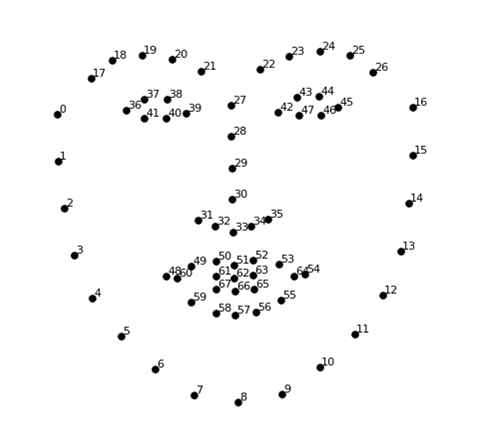

 - 생각보다 얼굴을 인식 못하는 경우가 많아서 여러 유형의 사진들을 사용했다.

다음은 얼굴 인식이 성공해 고양이 스티커 적용에 성공한 경우다. 많은 사진을 적용했지만 성공한 사진은 많지 않다. 

1. 멀리서 찍은 거의 정면에 가까운 사진 : 얼굴에 비춰진 조명이 딱히 없고 정면에 가까워서 예상대로 잘 인식했다.

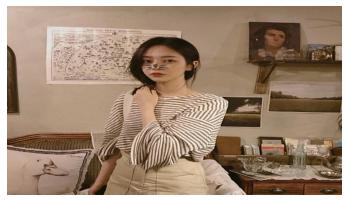 

2. 멀리서 찍은 약측면 사진 : 얼굴에 조명이 고르게 비춰지고 정면에 가까워서 인식했다.

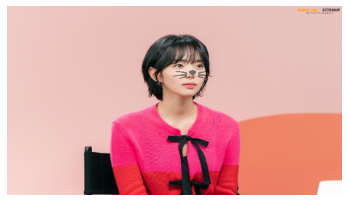

3. 측면에 가까운 사진 : 거의 측면에 가까운 사진이지만 두 눈이 모두 나와서인지 인식했다.

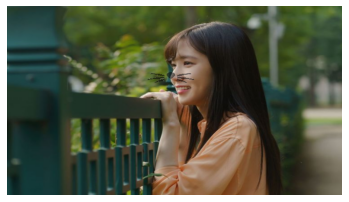

4. 어둠 속에서 찍은 정면 사진 : Image gradient를 얼굴 인식에 사용하므로 밝기 변화에도 인식했다.

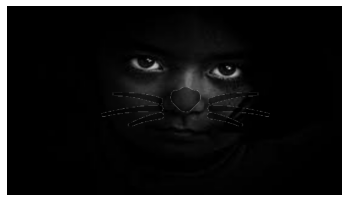

5. 코가 안보이는 만화 캐릭터 : 코가 거의 보이지 않지만 Landmark 인식에 성공했다. 인식에 성공한 것인지 코가 있어야 할 곳을 임의로 지정한 것인지는 잘 모르겠다.

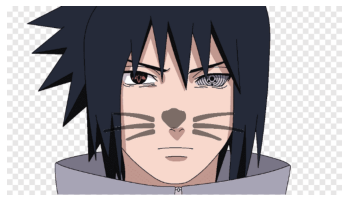

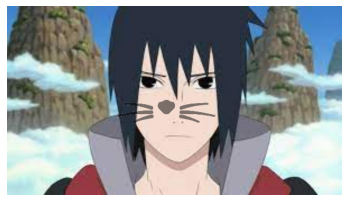

다음은 얼굴 인식이 실패한 경우다. 당연히 안 될 것이라고 생각한 이미지도 있고 '이게 왜 안되지' 하는 이미지도 있었다.

1. 누워 있는 사진 : face detector에서 누워있거나 측면 사진은 인식하지 못한다기에 확인 차 사용했고 역시 인식하지 못했다.

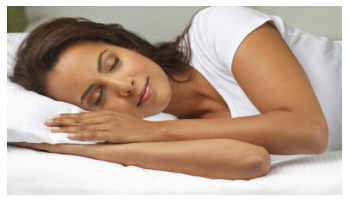

2. 얼굴의 일부분을 가린 사진 : 얼굴형과 눈, 코 위치를 정확하게 알 수 없어서 인지 인식하지 못했다.

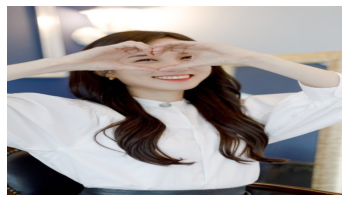

3. 얼굴의 일부분에만 조명을 받은 사진 : 일부분에만 조명을 받아 Image gradient 정보가 훼손돼서인지 인식하지 못했다. 

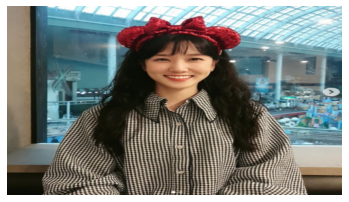

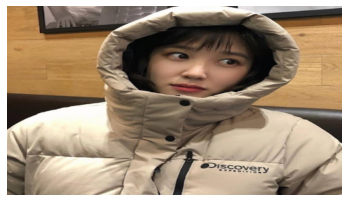

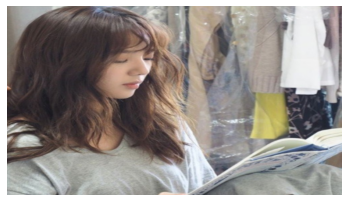

4. 왜 인식이 안됐는지 모르겠는 사진 : 조명도 비교적 고르게 받고 정면에 가까운 사진인데도 인식에 실패했다. 사진의 HoG를 따로 구해봤다.

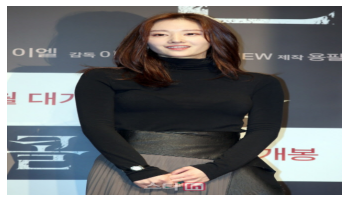

 - HoG를 보면 궁금증이 해소될 줄 알았는데 잘 모르겠다. 얼굴 검출을 위해 비교 대상이되는 HoG 패턴에 대해서 공부하지 않는 이상 해결하긴 힘들거 같다.

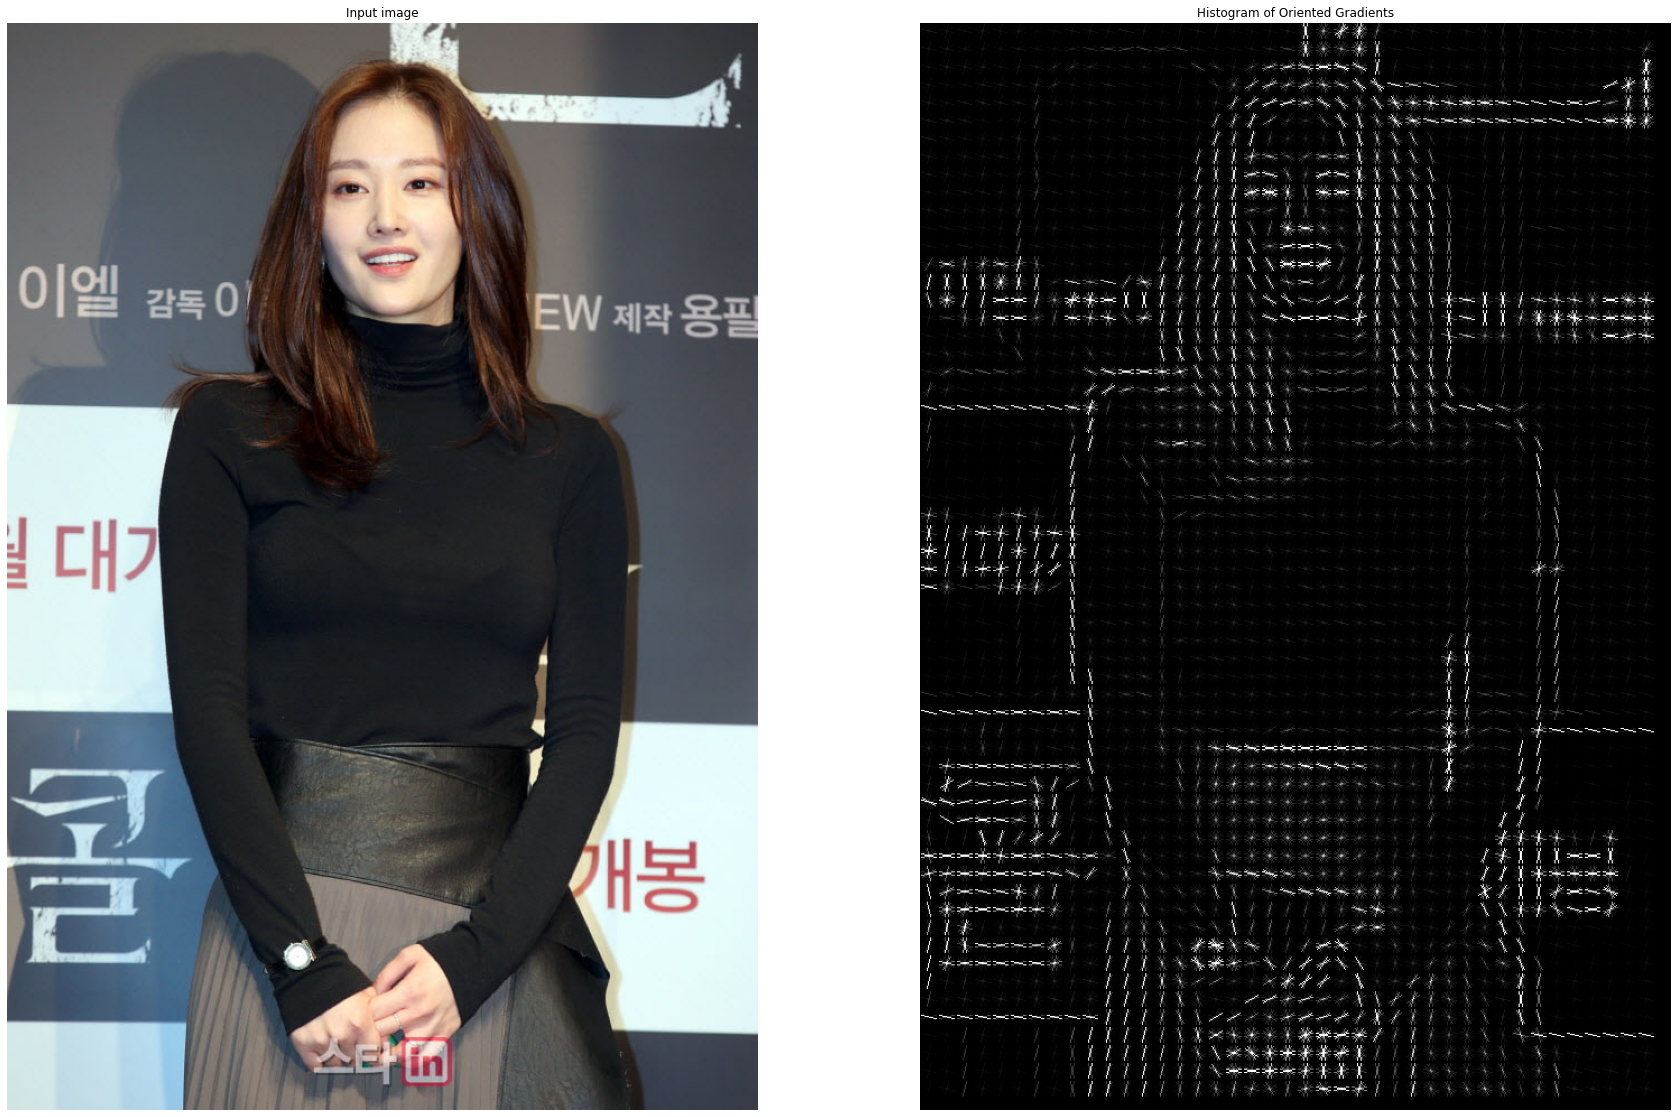

In [16]:
import matplotlib.pyplot as plt
import os
import cv2

from skimage.feature import hog
from skimage import exposure

my_image_path = os.getenv('HOME')+'/aiffel/camera_sticker/images/전종서.png'
image = cv2.imread(my_image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)


fd, hog_image = hog(image, orientations=8, pixels_per_cell=(16, 16),
                    cells_per_block=(1, 1), visualize=True, multichannel=True)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(30, 20), sharex=True, sharey=True)

ax1.axis('off')
ax1.imshow(image, cmap=plt.cm.gray)
ax1.set_title('Input image')

# Rescale histogram for better display
hog_image_rescaled = exposure.rescale_intensity(hog_image, in_range=(0, 10))

ax2.axis('off')
ax2.imshow(hog_image_rescaled, cmap=plt.cm.gray)
ax2.set_title('Histogram of Oriented Gradients')
plt.show()

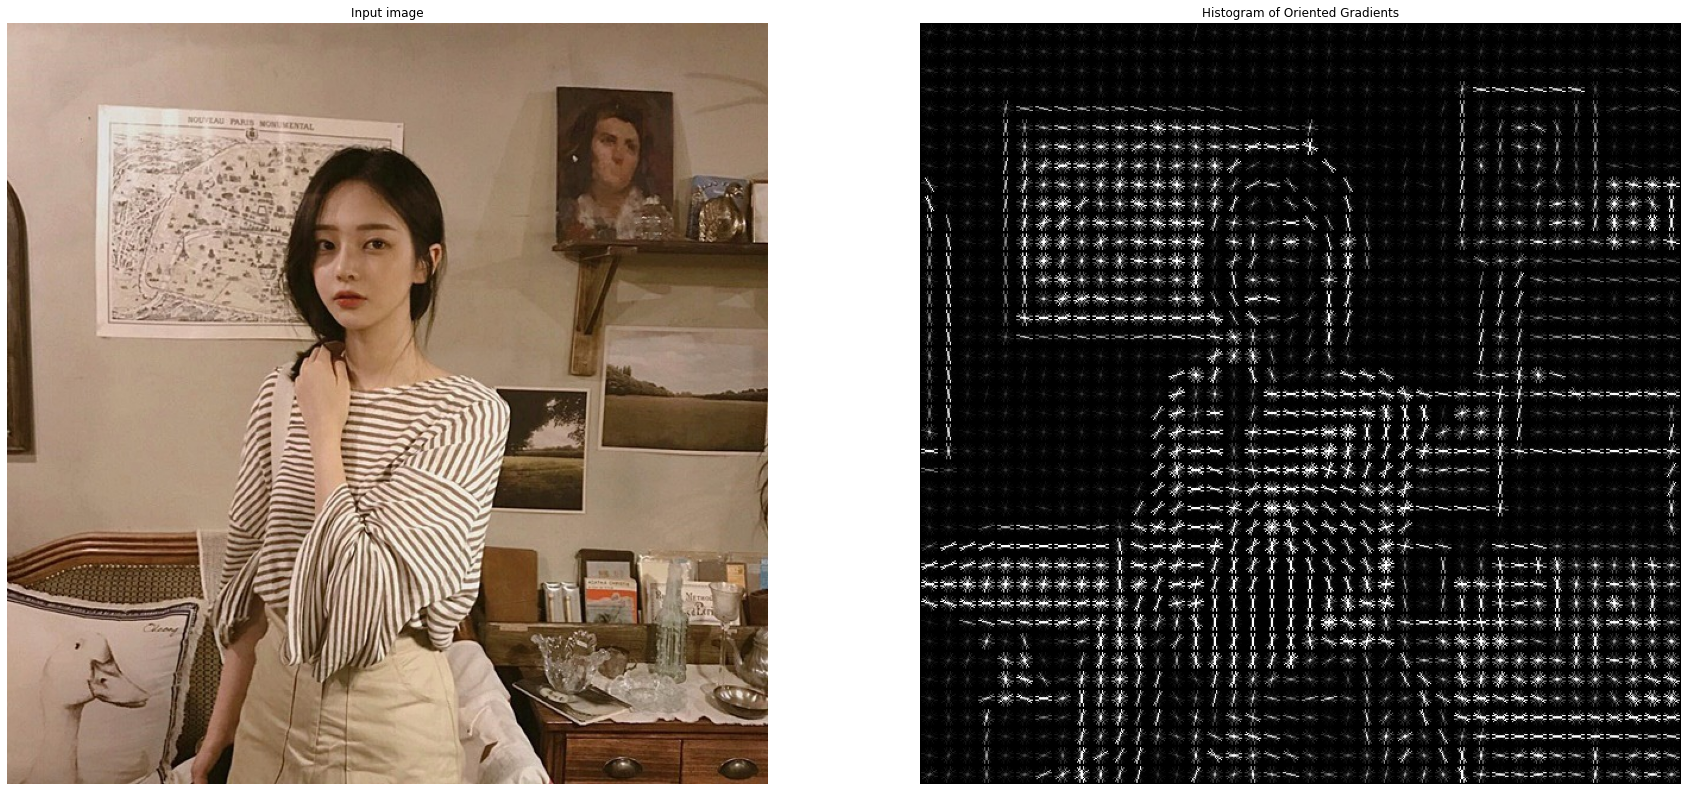

In [17]:
import matplotlib.pyplot as plt
import os
import cv2

from skimage.feature import hog
from skimage import exposure

my_image_path = os.getenv('HOME')+'/aiffel/camera_sticker/images/손화민.png'
image = cv2.imread(my_image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)


fd, hog_image = hog(image, orientations=8, pixels_per_cell=(16, 16),
                    cells_per_block=(1, 1), visualize=True, multichannel=True)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(30, 20), sharex=True, sharey=True)

ax1.axis('off')
ax1.imshow(image, cmap=plt.cm.gray)
ax1.set_title('Input image')

# Rescale histogram for better display
hog_image_rescaled = exposure.rescale_intensity(hog_image, in_range=(0, 10))

ax2.axis('off')
ax2.imshow(hog_image_rescaled, cmap=plt.cm.gray)
ax2.set_title('Histogram of Oriented Gradients')
plt.show()